# Missing Value Handling

Following our analysis of the missing values we will now explore some methods for missing value imputation.

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import missingno as msno
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

base_dir = os.path.join(os.getcwd(), os.pardir)
impute_dir = os.path.join(base_dir, "data/altered/imputed")

Load in the data.

In [5]:
data_path = os.path.join(base_dir, "data/altered/maps_feature_mapping.csv")
df = pd.read_csv(data_path, index_col="X")
features = df.columns

print(f"{df.shape[1]} features, {df.shape[0]} entries")
df.head()

82 features, 13734 entries


,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
X,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,30.0,59.294132,181.602831,107.0,NaN,NaN,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,NaN,9.0,26.0,NaN,NaN,85.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3,NaN,3.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,1.0,0.0
4,0.0,NaN,22.0,49.812426,160.224186,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0
5,0.0,8.0,31.0,62.270030,191.703227,132.0,1.0,NaN,0.0,0.0,...,NaN,NaN,NaN,1.0,0.0,1.0,2.0,2.0,0.0,0.0


For later imputation methods it is beneficial to have a list of feature types. We can get the type of each variable from the data dictionary.

We can create a dictionary to map feature names to their type.

In [6]:
dict_path = os.path.join(base_dir, "data/original/synthetic_data_dictionary.csv")
dict_df = pd.read_csv(dict_path)
dict_df = pd.DataFrame(dict_df[[dict_df.columns[0], dict_df.columns[3]]].dropna())
dict_df = dict_df.rename(columns={dict_df.columns[0]: "feature", dict_df.columns[1]: "type"})
dict_df = dict_df.set_index("feature")

type_dict = dict_df.to_dict()["type"]

Features are numerical (discrete or continuous) or categorical (nominal or ordinal). We shall keep track of which is which.

In [7]:
dis_features, con_features, nom_features, ord_features = [], [], [], []

for feature in df:
    ftype = type_dict[feature]
    if ftype == "Discrete":
        dis_features.append(feature)
    elif ftype == "Continuous":
        con_features.append(feature)
    elif ftype == "Nominal":
        nom_features.append(feature)
    elif ftype == "Ordinal":
        ord_features.append(feature)
    else:
        print(f"Unknown feature type - {feature} ({type_dict[feature]})")

num_features = dis_features + con_features
cat_features = nom_features + ord_features

It may also be useful to save which categorical features are binary.

In [8]:
bin_features = []
for feature in nom_features:
    unique = df[feature].dropna().unique()
    if len(unique) > 2:
        print(f"{feature} is non-binary")
    else:
        bin_features.append(feature)

print(f"There are {len(bin_features)} binary and {len(nom_features)-len(bin_features)} non-binary binary (nomial) categorical features.")

There are 24 binary and 0 non-binary binary (nomial) categorical features.


It appears all of the nominal features are binary. This is helpful as it means these features will not need to be one-hot encoded. Ordinal features have already been ordinally categorised and saved to `maps_feature_mapping.csv`.

## Simple Imputation Methods

We will first explore some simple imputation methods. These methods are the simplest both in implementation and computational cost. Generally they consist of replacing missing values in a feature with a value decided beforehand, or as we will discuss next, removing them entirely.

### Dropping values

The simplest method for handling missing values is to simply drop them from the dataset. This method can sometimes be the best as it doesn't require assumptions about the data to impute missing values.

We can either drop a row if it has missing values, or we can drop an entire feature. Dropping a row from a dataset means you do not reduce the dimensionaliy of the data but you will lose a datapoint, dropping a feature means you lose some descriptor from every datapoint. Unless the feature has little information (e.g. all values for that feature are the same), then it is usually not a good idea to drop features.

Dropping rows will not work for our dataset as there are no fully-complete rows - each entry has at least one missing feature. As explained above we will also not be removing any features as they all hold information, so we will need to carry out some form of imputation on our data.

### NaN as a Category

Rather than dropping the missing valeus, we can instead replace all NaN values with a new value which marks it as a missing value such as `-1`. This can be useful if you think the reason there are missing values in a feature is because that value being missing is a data point itself. For example, if a question in a survey has only the option to answer yes, many will leave this blank to say no giving a lot of missing data for that feature - we will look at this next.

Generally though we do not want to replace missing values in the dataset with a missing value indicator. Not only because (most) of the features are fully described by their categories (or are numerical), but also because there are so many missing values. A lot of the features have over 60% of their values missing and so imputing all of these as a new category (or value) would heavily skew the distribution of the data.

Instead we shall aim to use for sophisticated imputation techniques.

### Logical substitutions

Before proceeding with imputation methods there are some features which need to be attended to following our previous analysis of the missing values.

#### Binary features with single unique value

The features `comp_house`, `comp_int_bed_16`, `comp_noint_bed_16` and `tv_bed_16` all have only one unique value other than NaN. In reality these features are binary and would be either `Yes` or `No`. Before continuing with any other imputation method we must ensure there are some `No` values for these features, otherwise the imputation will likely set all as `Yes` as these are the only possible values it sees.

We cannot simply impute all the missing values as `No` as there are far too many, which would skew the data. Instead we can make some logical substitutions of the NaN values based on the feature descriptions and how they relate to other features.

Looking at the descriptions for the features:

|Variable Name |Variable Description |
|:-- |:-- |
|comp_house |Computer without internet access is in the house but not in the study child's room |
|comp_int_bed_16 |Computer with internet access is more or less permanently study child's room |
|comp_noint_bed_16 |Computer without internet access is more or less permanently in study child's room |
|tv_bed_16 |Study child has a TV set more or less permanently in their room |

Some logical assumptions we can make are:

- If `comp_noint_bed_16` is `Yes`, then `comp_int_bed_16` should be `No`.
- If `comp_int_bed_16` is `Yes`, then `comp_noint_bed_16` should be `No`.
- If `comp_noint_bed_16` is `Yes`, then `comp_house` should be `No`.
- If `comp_house` is `Yes`, then `comp_noint_bed_16` should be `No`.
- If `comp_week` and `comp_wend` are `Not at all` then `comp_house` should be `No`. 
- If `tv_week` and `tv_wend` are `Not at all` then `tv_bed_16` should be `No`. 

Imputing using this method should allow for some of the values to, but should impute enough `No` values to these columns for other imputation methods to start working giving some more variability.


In [9]:
sub_df = df.copy()

sub_df.loc[(sub_df["comp_noint_bed_16"] == 1.0), "comp_int_bed_16"] = 0.0
sub_df.loc[(sub_df["comp_int_bed_16"] == 1.0), "comp_noint_bed_16"] = 0.0
sub_df.loc[(sub_df["comp_noint_bed_16"] == 1.0), "comp_house"] = 0.0
sub_df.loc[(sub_df["comp_house"] == 1.0), "comp_noint_bed_16"] = 0.0
sub_df.loc[(sub_df["comp_week"] == 1.0) & (sub_df["comp_wend"] == 1.0), "comp_house"] = 0.0
sub_df.loc[(sub_df["tv_week"] == 1.0) & (sub_df["tv_wend"] == 1.0), "tv_bed_16"] = 0.0

sub_df

,comp_bed_9,mat_dep,mat_age,weight_16,height_16,iq,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,...,dep_score,comp_house,tv_bed_16,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
X,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,30.0,59.294132,181.602831,107.0,0.0,NaN,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,NaN,9.0,26.0,NaN,NaN,85.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3,NaN,3.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,1.0,0.0
4,0.0,NaN,22.0,49.812426,160.224186,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0
5,0.0,8.0,31.0,62.270030,191.703227,132.0,1.0,0.0,0.0,0.0,...,NaN,0.0,NaN,1.0,0.0,1.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13730,NaN,13.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,0.0,0.0
13731,0.0,6.0,29.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,1.0,0.0
13732,NaN,21.0,37.0,58.075832,169.235565,108.0,NaN,NaN,1.0,2.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Lets see how many values were filled in for these features.

In [10]:
num_samples = len(sub_df)
single_features = [
    "comp_noint_bed_16", "comp_int_bed_16", "comp_house", "tv_bed_16"
]

for feature in single_features:
    nan_count = sub_df[feature].isna().sum()
    value_counts = sub_df[feature].value_counts().sort_values("index")
    print(f"{feature}:\n\
        No count = {value_counts[0]}\n\
        Yes count = {value_counts[1]}\n\
        NaN count = {nan_count} ({100*nan_count/num_samples:.2f}%)\n")

comp_noint_bed_16:
        No count = 2898
        Yes count = 471
        NaN count = 10365 (75.47%)

comp_int_bed_16:
        No count = 471
        Yes count = 2446
        NaN count = 10817 (78.76%)

comp_house:
        No count = 975
        Yes count = 567
        NaN count = 12192 (88.77%)

tv_bed_16:
        No count = 462
        Yes count = 3648
        NaN count = 9624 (70.07%)



Although a high number of values are still `NaN`, this amount is inline with other features in the dataset so it should be a good starting point for other imputation methods.

Lets save this new dataset.

In [11]:
save_csv_path = os.path.join(base_dir, "data/altered/imputed/maps_fixed_binary.csv")
sub_df.to_csv(save_csv_path)

#### DAWBA band features with missing band entries

For all depression and anxiety band features we have values of 0-5; these map to the following DAWBA bands for child mental health.

|Category |DAWBA Band |
|:-- |:--- |
|0 |<0.1% |
|1 |~0.5% |
|2 |~3% |
|3 |~15% |
|4 |~50% |
|5 |>70% |

Each of the `anx_band` and `dep_band` features have at least some entries apart from `anx_band_07`, which is without any 0 values. Similarly to above, this may cause issues with some imputation methods resulting in no NaN values being filled with a `0` category which is unlikely.

The `anx_band` and `dep_band` features have high correlation between eachother as seen in our feature correlation analysis. This makes logical sense as although different conditions entirely, depression and anxiety are closely linked; in patients suffering from both conditions, the effects of one condition will often worsen symptoms of the other.

We can use this knowledge to make some logical assumptions about children with missing values for the `anx_band_07` feature. It may not be enough to simply impute `0` for all children with 0 for `dep_band_07`, but if we also look forward to `anx_band_10` and `dep_band_10` and these are also both `0` this should be a strong enough indication that `anx_band_07` was likely `0`.

In [12]:
ad_df = sub_df[["anx_band_07", "dep_band_07", "anx_band_10", "dep_band_10"]].copy()

ad_df[
    (ad_df["anx_band_07"].isna())  
    & (ad_df["dep_band_07"] == 0.0)
    & (ad_df["anx_band_10"] == 0.0)
    & (ad_df["dep_band_10"] == 0.0)
]

,anx_band_07,dep_band_07,anx_band_10,dep_band_10
X,,,,


Unfortunately it seems all of these columns are missing a lot of values. No rows meet this criteria for imputation, the only condition that gives reasonable results is when `anx_band_07` is missing and `dep_band_10` is `0`, which is not something which would make sense to map `anx_band_07` to directly. We shall leave the `anx_band_07` column as is as there is no substition we can make based off strong enough correlations with other columns. 

The fact that NaN values are missing when none of the other features are `0` suggests that the features are missing not at random (MNAR). This would make sense as `0` maps to the DAWBA band of `<0.1%`, so a lot of the missing entries are likely representing the child not having anxiety and so not knowing their anxiety band.

Using this information we can change our substition criteria to say if at least one of these rows are `0` and the others are missing, then we can assume `anx_band_07` is `0`.

In [13]:
ad_df[
    (ad_df["anx_band_07"].isna())  
    & (ad_df[["dep_band_07", "anx_band_10", "dep_band_10"]].sum(axis=1) == 0.0)
    & ~ (ad_df["dep_band_07"].isna() & ad_df["anx_band_10"].isna() & ad_df["dep_band_10"].isna()) 
]

,anx_band_07,dep_band_07,anx_band_10,dep_band_10
X,,,,


This also gives no results, which suggests the `0` value is uncommon. Let's check the value counts for each of the band features and see if we can spot any patterns.

In [14]:
bands = [
    "anx_band_07", "anx_band_10", "anx_band_13", "anx_band_15",
    "dep_band_07", "dep_band_10", "dep_band_13", "dep_band_15",
]

df_count = pd.DataFrame(columns=bands, index=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
df_count.index.name = "DAWBA"

counts = [df[band].value_counts() for band in bands]
for count in counts:
    df_count[count.name] = count

df_count

,anx_band_07,anx_band_10,anx_band_13,anx_band_15,dep_band_07,dep_band_10,dep_band_13,dep_band_15
DAWBA,,,,,,,,
0.0,NaN,4,15,3.0,5050.0,4500.0,4022.0,1831.0
1.0,3856.0,3019,2881,1953.0,2802.0,2813.0,2553.0,2976.0
2.0,3907.0,4167,3821,2740.0,NaN,NaN,NaN,NaN
3.0,370.0,528,338,508.0,188.0,294.0,355.0,403.0
4.0,74.0,66,72,99.0,49.0,66.0,54.0,75.0
5.0,73.0,68,31,NaN,NaN,6.0,19.0,14.0


As expected, there are not a lot of `0` values for the anxiety band features. There are not a lot of higher values either and this is the same for the depression bands. Interestingly there are also no band `2` values for any entry at any age.

Rather than imputing these values it may make sense to combine the DAWBA bands into low (0-1), medium (2-3) and high (4-5), this would mean there are values for each band for each band feature.

Lets apply this to `maps_fixed_binary` from the previous imputation step.

In [15]:
band_map = {
    0.0: 0.0,
    1.0: 0.0,
    2.0: 1.0,
    3.0: 1.0,
    4.0: 2.0,
    5.0: 2.0,
}

csv_path = os.path.join(base_dir, "data/altered/imputed/maps_fixed_binary.csv")
band_df = pd.read_csv(csv_path).set_index("X")
band_df[bands] = band_df[bands].replace(band_map)
band_df[bands]

,anx_band_07,anx_band_10,anx_band_13,anx_band_15,dep_band_07,dep_band_10,dep_band_13,dep_band_15
X,,,,,,,,
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
5,NaN,0.0,0.0,1.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
13730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13731,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
13732,0.0,1.0,0.0,1.0,0.0,NaN,0.0,2.0


Let's now check all the features have at least a few entries for the new reduced bands.

In [16]:
df_count = pd.DataFrame(columns=bands, index=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
df_count.index.name = "DAWBA"

counts = [band_df[band].value_counts() for band in bands]
for count in counts:
    df_count[count.name] = count

df_count

,anx_band_07,anx_band_10,anx_band_13,anx_band_15,dep_band_07,dep_band_10,dep_band_13,dep_band_15
DAWBA,,,,,,,,
0.0,3856.0,3023.0,2896.0,1956.0,7852.0,7313.0,6575.0,4807.0
1.0,4277.0,4695.0,4159.0,3248.0,188.0,294.0,355.0,403.0
2.0,147.0,134.0,103.0,99.0,49.0,72.0,73.0,89.0
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As expected all features now have values for the new bands `0`-`2`. Initial analysis also appears that value counts decrease across all features as the band increases which is to be expected.

We can now save this dataframe to a new CSV for use with imputation.

In [17]:
save_csv_path = os.path.join(base_dir, "data/altered/imputed/maps_fixed_binary_bands.csv")
band_df.to_csv(save_csv_path)

## Univariate Imputation Methods

Univariate imputation methods impute missing values in a feature based on calculations made on values from that feature. They provide reasonable imputation values, but lack any encoding of inter-feature relationships.

### Mean, Median and Mode Imputation

This simple method of imputation consists of filling all missing values for a feature with the mean, median or mode value for the column.

For numerical features the most common choice would be mean imputation, although if the data is highly skewed to one side (long left/right-hand tail) it may make more sense to use the median, e.g. for income and wealth features.

For categorical features the mode of the feature should be used, i.e. assume that missing values will be the most common category.

In [19]:
to_impute_path = os.path.join(base_dir, "data/altered/imputed/maps_fixed_binary_bands.csv")
meanmode_path = os.path.join(base_dir, "data/altered/imputed/maps_meanmode_impute.csv")
toimpute_df = pd.read_csv(to_impute_path).set_index("X")
meanmode_df = toimpute_df.copy()

# mean impute numerical and mode impute categorical features
mean_imputer = SimpleImputer(strategy="mean")
mode_imputer = SimpleImputer(strategy="most_frequent")
meanmode_df[num_features] = mean_imputer.fit_transform(toimpute_df[num_features])
meanmode_df[cat_features] = mode_imputer.fit_transform(toimpute_df[cat_features])

# save csv and ensure all there are no missing values
meanmode_df.to_csv(meanmode_path)
print(f"missing values in dataframe: {meanmode_df.isna().sum().sum()}")

missing values in dataframe: 0


Unless dealing with a very small amount of missing data it is best to avoid this method of imputation as it decreases the variance in the data, affecting the distribution of the data and so any analysis of this data will be wrong as a result of this. We have a lot of missing data, so will need to look at other methods, but first lets check the distribution of a few of the newly imputed features.

In [20]:
num_features

['mat_dep',
 'iq',
 'agg_score',
 'parity',
 'secd_diag',
 'prim_diag',
 'weight_16',
 'height_16']

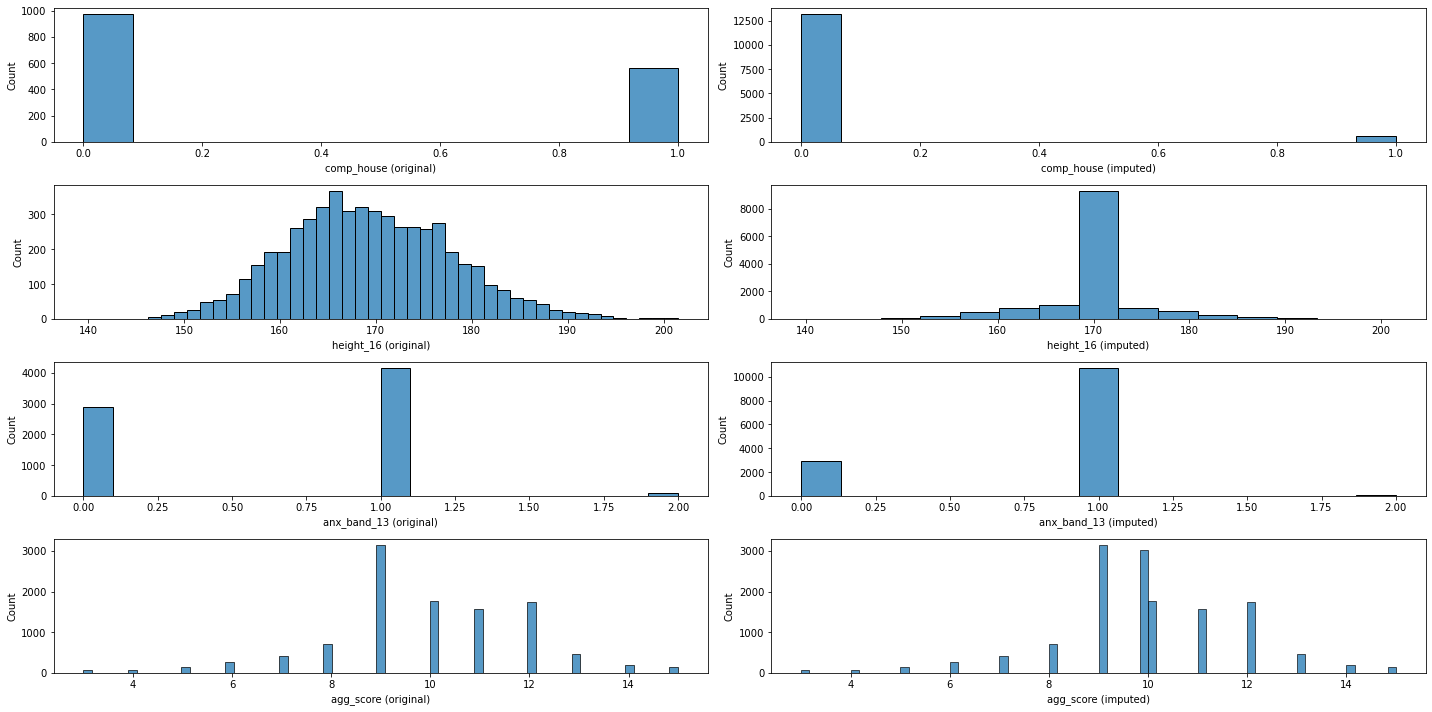

In [21]:
n = 4
features = ["comp_house", "height_16", "anx_band_13", "agg_score"]

# tickrange = np.arange(0, 15000, step=2000)
fig = plt.figure(figsize=(20,10))
plt.title("Distribution of Features - Oringnal vs. After Mean/Mode Imputation")
for i, feature in enumerate(features):
    ax0 = plt.subplot(n, 2, 2*i+1)
    ax0 = sns.histplot(toimpute_df[feature])
    ax0 = plt.xlabel("{} (original)".format(feature))
    # ax0 = plt.xticks(toimpute_df[feature].dropna().sort_values().unique())
    # ax0 = plt.yticks(tickrange)
    ax1 = plt.subplot(n, 2, 2*i+2)
    ax1 = sns.histplot(meanmode_df[feature])
    ax1 = plt.xlabel("{} (imputed)".format(feature))
    # ax1 = plt.xticks(toimpute_df[feature].dropna().sort_values().unique())
    # ax1 = plt.yticks(tickrange)  
fig.tight_layout()

Looking at these plots it is clear one value for each feature is now greatly over represented in the data. This changes the distribution of the data compared to the real data, so we shall move on to other methods which take this further into account.

### Hot-Deck Imputation

Hot-deck imputation is an method in which missing values from a feature are filled in by a random value present in that feature.

In [50]:
hotdeck_df = toimpute_df.copy()

for col in hotdeck_df:
    unique = hotdeck_df[col].dropna().unique()
    for i, value in enumerate(hotdeck_df[col]):
        if pd.isna(value):
            hotdeck_df.at[i+1, col] = np.random.choice(unique)

hotdeck_path = os.path.join(base_dir, "data/altered/imputed/maps_hotdeck_impute.csv")
hotdeck_df.to_csv(hotdeck_path)

The issue with this imputation method is that imputations are completely random. This results in data which does not follow the real distribution and certainly doesn't retain any inter-feature relationships.

A better method of one-hot imputation is called `last observarion carried forward (LOCF)`. In this method, values in the dataset are ordered by one of the features, missing values are then imputed as the previous non-missing value.

For example, we could use the feature `dep_score` for this method. Note: there are a few missing values at the start of the dataframe which won't be filled by this method so we apply a backfill to fill them, i.e. the reverse of LOCF.

In [69]:
locf_df = toimpute_df.copy().sort_values("dep_score")

locf_df.ffill(inplace=True)
locf_df.backfill(inplace=True)

locf_path = os.path.join(base_dir, "data/altered/imputed/maps_locf_impute.csv")
locf_df.to_csv(locf_path)

The issue with this method is that it introduces a lot of bias, based on the the feature used to order the dataset. Another problem is that whichever feature we choose to order by, we will have a lot of missing data in that feature. This is a problem as all of the missing values will be grouped together, treating them as their own value rather than imputing them intelligentely.

This method is more suited for time-series data, where you can sort by timestamp which would introduce less bias than naively assuming all features can be sorted by `dep_score` as our example has done here.

## Multivariate and Model-Based Imputation Methods

In a dataset you will find features correlate with one-another. We can use this to infer missing values from the non-missing features of each entry.

Model-based approaches aim to model each feature as a function of other features. This allows predictions of the missing value to be made which can be far more accurate than simple univariate imputation methods such as mean and mode.

### K-Nearest Neighbour Imputation

K-nearest neighbours (KNN) is an unsupervised machine learning technique which attempts to classify values based on their distance to other values in the dataset. It takes into account all features and is capable of good results with low computational cost. KNN can be used for imputation by imputing the missing value as the mean of the neighbouring cluster.

The distance measure used in the KNN clustering is the most important part of KNN imputation. For numerical features it is valid to used the Euclidean distance; it works well in high dimensional space and is well defined for numerical values. 

Categorical features on the other hand are more difficult to handle. You cannot say the distance between two categories is similar to the Euclidean distance between two numerical data points. Even when categorical features are ordinal, the distance between each category is not the same. 

Take for example the 3 categories `never`, `sometimes` and `all the time`, which could be encoded as `0, 1, 2`. You may then say the distance between `never` and `all the time` is `2-0 = 2`, but some may argue the real distance between `never` and `all the time` is infinite. 

This becomes an issue when trying to calculate distance between datapoints in KNN imputation. Hamming distance is a common metric used for categorical distance, but it relies on categories being ordinal (and encoded orderly) and ignores any real distance which could be inferred such as the `never` and `all the time` example mentioned above.

Another issue with this is numerical and categorical features cannot be used with one-another during imputation due to their differing distance metric requirements. This means imputation is calculated for categorical features without information from numerical features and vice versa. This seems a particular issue for the numerical features in this dataset due to the high proportion of categorical features to numerical features meaning a lot of information is ignored.

In [71]:
knn_df = toimpute_df.copy()

# note: must define nan-supported hamming distance for cat variables
knn_cat_imputer = KNNImputer(n_neighbors=5, metric="hamming")
knn_num_imputer = KNNImputer(n_neighbors=5, metric="euclidean")

# knn_df[cat_features] = knn_cat_imputer.fit_transform(knn_df[cat_features])
# knn_df[num_features] = knn_num_imputer.fit_transform(knn_df[num_features])

As mentioned earlier distance is not a well defined metric for categorical variables. Hamming distance is a more sensible choice than Euclidean, but it still assumes some distance between the categories. Lukily all our categorical features are binary or ordinal (not nominal) so this works to some extent, but is still not an ideal encoding. Future work should explore more advanced distance metrics for categorical features.

Another issue with the KNN imputation method is that it does not perform well on high-dimensional data. This is because in high-dimensional space each data point can seem equally far away from eachother and so KNN imputation works better with a lower number of features.

There is also the problem of specifying the number of neighbours to take into consideration when calculating imputation values. It is thought the higher the number of missing values in the dataset, the larger number of neighbours you should consider. Given the high proportion of missing values from a number of the features in this dataset we should probably experiment with using a larger number of neighbours.

### Imputation by Linear and Logistic Regression

Model-based approaches model each feature as a function of other features. Using linear regression we can model the numerical features as functions of one-another and make predictions of the missing values using these functions. Similarly we can train a logistic regression classifier to make predictions of the missing values using the other features.

In order to make these predictions we will use the rows with values for a feature as the training set and rows with missing values as the test set to make predictions from. So we have all the values filled for all other features, we shall use the mean/mode imputation dataset from earlier to train our models and make predictions from. The predictions will then replace the mean/mode impuations.

In [398]:
# use meanmode dataset for training
meanmode_df = pd.read_csv(meanmode_path).set_index("X")
reg_df = toimpute_df.copy()
# iterate each feature with tqdm
for i, feature in enumerate(tqdm(reg_df.columns)):
    # break if no nans in feature
    if reg_df[feature].isna().sum() == 0:
        continue
    # seperate feature column
    X = meanmode_df.drop(feature, axis=1, inplace=False).to_numpy()
    y = reg_df[feature].copy().to_numpy()
    # scale X
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # get position of nans and non-nans
    nans = [n for [n] in np.argwhere(np.isnan(y.tolist()))]
    notnans = [n for [n] in np.argwhere(~np.isnan(y.tolist()))]
    # create train set from non-nan values
    X_train = np.take(meanmode_df.to_numpy(), notnans, axis=0)
    X_pred = np.take(meanmode_df.to_numpy(), nans, axis=0)
    y_train = np.take(y, notnans)
    # linear regression for numerical and logistic for categorical
    if feature in num_features:
        reg = LinearRegression(n_jobs=-1)
    elif feature in bin_features:
        reg = LogisticRegression(solver="liblinear", multi_class="ovr", dual=False, max_iter=2500)
    else: # ordinal category
        reg = LogisticRegression(solver="lbfgs", multi_class="multinomial", dual=False, max_iter=2500, n_jobs=-1)
    # train regressor and predict nan values
    reg.fit(X_train, y_train)
    preds = reg.predict(X_pred)
    # fill dataframe with predictions
    y[nans] = preds
    reg_df[feature] = y

100%|██████████| 82/82 [12:51<00:00,  9.41s/it]


Now we can save the new dataframe.

In [405]:
reg_path = os.path.join(base_dir, "data/altered/imputed/maps_linlog_reg_impute.csv")
reg_df.to_csv(reg_path)

There are a number of issues with this method of imputation. Firstly, these models imply a linear relationship between features in order to make their predictions, which is unlikely given some of the low correlations we observed during our initial correlation analysis. 

This method also has the issue of making quite ridgid predictions, it will always produce the same result given an input which will reduce the variation in the data. Imagine a 2D scatter plot which follows a rough linear correlation; you could plot a line of best fit and data points would be close to this line but not fit it exactly. This method will only produce imputations that fall exactly on that line.

Possibly the most obvious issue is the fact we used the mean/mode imputed dataset for both training of our models and predictions. As discussed earlier this dataset is massively skewed and has far less correlation than the original data, which will obviously influence what the models can learn. We will get to some methods of solving this issue later.

### Stochastic Reggression Imputation

Stochastic regression is a method of imputation which follows the same steps as the above method but with an added feature aiming to solve the issue of ridgid predictions we saw with standard regression.

As the same suggests this method uses regression, but adds some randomness to the data. When a prediction is made by a model there is an added randomness to the output. Deciding on how this randomness is added will affect the resulting imputations, but this implementation follows these rules:

- Ordinal categorical variables have a 10% chance to differ by 1 category than the prediction.
- Binary categorical variables have a 10% chance to output the opposite of the prediction.
- Numerical variables output a value from a normal distribution centred around the prediction where values should fall within +- 10% of the prediction.

In [81]:
def add_stochastic(x, df_f, ftype):
    """
    - ~10% chance for input to move up or down one for categorical features
    - 10% jitter to numerical features.
    """
    unique = df_f.unique()
    if ftype == "ord":
        s = np.random.choice([x-1, x, x+1], p=[0.05, 0.9, 0.05])
        if s in unique:
            return s
    if ftype == "bin":
        s = np.random.choice([x, x+1], p=[0.9, 0.1]) % 2
        return s
    else:
        s = np.random.normal(x, 3)
        return s
    return x

# use meanmode dataset for training
meanmode_df = pd.read_csv(meanmode_path).set_index("X")
sto_reg_df = toimpute_df.copy()
# iterate each feature with tqdm
for i, feature in enumerate(tqdm(sto_reg_df.columns)):
    # break if no nans in feature
    if sto_reg_df[feature].isna().sum() == 0:
        continue
    # seperate feature column
    X = meanmode_df.drop(feature, axis=1, inplace=False).to_numpy()
    y = sto_reg_df[feature].copy().to_numpy()
    # scale X
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # get position of nans and non-nans
    nans = [n for [n] in np.argwhere(np.isnan(y.tolist()))]
    notnans = [n for [n] in np.argwhere(~np.isnan(y.tolist()))]
    # create train set from non-nan values
    X_train = np.take(meanmode_df.to_numpy(), notnans, axis=0)
    X_pred = np.take(meanmode_df.to_numpy(), nans, axis=0)
    y_train = np.take(y, notnans)
    # linear regression for numerical and logistic for categorical
    if feature in num_features:
        reg = LinearRegression(n_jobs=-1)
        ftype = "num"
    elif feature in bin_features:
        reg = LogisticRegression(solver="liblinear", multi_class="ovr", dual=False, max_iter=2500)
        ftype = "bin"
    else: # ordinal category
        reg = LogisticRegression(solver="lbfgs", multi_class="multinomial", dual=False, max_iter=2500, n_jobs=-1)
        ftype = "ord"
    # train regressor and predict nan values
    reg.fit(X_train, y_train)
    preds = reg.predict(X_pred)
    # add randomness
    stochastic_preds = [add_stochastic(pred, meanmode_df[feature], ftype) for pred in preds]
    # fill dataframe with predictions
    y[nans] = stochastic_preds
    sto_reg_df[feature] = y

100%|██████████| 82/82 [13:46<00:00, 10.08s/it]


Now we can save the dataframe.

In [82]:
sto_reg_path = os.path.join(base_dir, "data/altered/imputed/maps_stochastic_linlog_reg_impute.csv")
sto_reg_df.to_csv(sto_reg_path)

Although still suffering from issues of assuming linearity between features and using mean/mode imputation as input, the imputed values from this method should produce more natural results with a variance closer to the real data due to the added randomness.

One major issue with this method is how the added randomness affects the resulting imputations. We have added the same amount of randomness to each of the feature types, but a better method may look at how each of the current values vary and adding some level of randomness to each feature which we have inferred from the real data.

### Random Forest Imputation

A random forest is a bagged ensemble of decision trees. It makes use of ensemble learning to produce highly accurate models using decision trees to learn from high-dimensional non-linear data. This makes it a perfect candidate for imputation of our data. 

We can use it in much the same way as our previous method, replacing linear regression with a random forest regressor and logistic regression with a random forest classifier.

In [77]:
# use meanmode dataset for training
meanmode_df = pd.read_csv(meanmode_path).set_index("X")
rf_df = toimpute_df.copy()
# iterate each feature with tqdm
for i, feature in enumerate(tqdm(rf_df.columns)):
    # break if no nans in feature
    if rf_df[feature].isna().sum() == 0:
        continue
    # seperate feature column
    X = meanmode_df.drop(feature, axis=1, inplace=False).to_numpy()
    y = rf_df[feature].copy().to_numpy()
    # get position of nans and non-nans
    nans = [n for [n] in np.argwhere(np.isnan(y.tolist()))]
    notnans = [n for [n] in np.argwhere(~np.isnan(y.tolist()))]
    # create train set from non-nan values
    X_train = np.take(meanmode_df.to_numpy(), notnans, axis=0)
    X_pred = np.take(meanmode_df.to_numpy(), nans, axis=0)
    y_train = np.take(y, notnans)
    # regression for numerical and classification for categorical
    if feature in num_features:
        rf = RandomForestRegressor()
    elif feature in cat_features:
        rf = RandomForestClassifier()
    # train regressor and predict nan values
    rf.fit(X_train, y_train)
    preds = rf.predict(X_pred)
    # fill dataframe with predictions
    y[nans] = preds
    rf_df[feature] = y

100%|██████████| 82/82 [01:11<00:00,  1.15it/s]


Save imputed dataset.

In [78]:
rf_path = os.path.join(base_dir, "data/altered/imputed/maps_randomforest_impute.csv")
rf_df.to_csv(rf_path)

A random forest should be able to learn a lot more from the data than linear and logistic regression as it does not assume the relationships between features are linear. It does also not suffer from the same 'rigid' prediction issue and has a level of randomness to its training method which results in different solutions each time.

### Issues with Our Current Model-Based Approaches

Although the above mluti-variate imputation methods are able to encode complex information from all features to produce intelligent imputation predictions, they are ultimately flawed by the fact we must initially impute all missing values using the simple univariate mean/mode imputation method to make our predictions from.

Doing so would not be as much of an issue had it not been for the large number of missing values from our data. Because these imputation methods start of at a point where ~60% of the values are now simply the mean or mode of their feature; whichever model-based approach we use is not going to be able to learn the original underlying distribution due to the initial imputation method skewing the distribution as described in the mean/mode imputation section above. Instead it is likely to learn that ~60% of the values can be described by one category or single numerical value.

This means, although better than simple mean/mode imputation, most of the variance in the original data is still lost. A better imputation method would be able to handle missing values in a way that didn't rely on simple imputation of the mean or mode.

### Gradient Boosting Imputation

Similarly to random forest, gradient boosting makes use of an ensemble of decision trees but rather than bagging them together it uses gradient boosting.

`XGBoost` is an implementation of gradient boosting with a number of performance improvements. It is often one of the top performing models in machine learning competitions and has the unqiue ability of self-handling missing values, being able to learn from and predict values using datasets with missing data.

We can use this to improve upon out random forest imputation method. Where previously we had to start imputation using mean/mode imputation, using `XGBoost` we do not. We can train a gradient boosting model to make predictions of the missing values without ever introducing assumptions of initial values. This should reduce the loss of variance we see from imputing such as large number of values as the mean or mode.

In [88]:
# use meanmode dataset for training
train_df = toimpute_df.copy()
xgb_df = toimpute_df.copy()
# iterate each feature with tqdm
for i, feature in enumerate(tqdm(xgb_df.columns)):
    # break if no nans in feature
    if xgb_df[feature].isna().sum() == 0:
        continue
    # seperate feature column
    X = train_df.drop(feature, axis=1, inplace=False).to_numpy()
    y = xgb_df[feature].copy().to_numpy()
    # get position of nans and non-nans
    nans = [n for [n] in np.argwhere(np.isnan(y.tolist()))]
    notnans = [n for [n] in np.argwhere(~np.isnan(y.tolist()))]
    # create train set from non-nan values
    X_train = np.take(train_df.to_numpy(), notnans, axis=0)
    X_pred = np.take(train_df.to_numpy(), nans, axis=0)
    y_train = np.take(y, notnans)
    # regression for numerical and classification for categorical
    if feature in num_features:
        xgb = XGBRegressor(verbosity=0)
    elif feature in cat_features:
        xgb = XGBClassifier(verbosity=0)
    # train regressor and predict nan values
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_pred)
    # fill dataframe with predictions
    y[nans] = preds
    xgb_df[feature] = y

100%|██████████| 82/82 [00:33<00:00,  2.43it/s]


Save imputed dataset.

In [90]:
xgb_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
xgb_df.to_csv(xgb_path)

While this method seems like magic, it is a little unclear how it is imputing the missing values and with so many missing we cannot be sure the predictions make sense.

## Iterative Imputation

Rather than rely on `XGBoost` for its ability to handle missing values, we can look back to our previous method of starting with mean/mode imputation and make some alterations. 

We found that mean / mode imputation over-represented single values, decreasing variance and destroying the underlying distribution of the data. Using this as a starting point for model-based approaches meant that this reduced variance resulted in more inaccurate missing value prediction, but they were better than the simple mean/mode method.

If we iterate this step and take the outputted missing values from the model-based approach as the input to another model it should can produce new values based on this better input. This process can be repeated until a point of convergence, i.e. when the model stops making alterations to the inputed values and has produced a best predictor.

### Iterative Random Forest Imputation

As we have seen the properties of decision trees and ensemble learning mean random forests can work well as imputers for high-dimensional non-linear data such as ours. We can use the iterative method just described to improve upon our previous random forest imputation method, hopefully retaining more variance in the data by iteratively applying the imputed results back into the imputer until we reach a point on convergence.

In [136]:
# note: assume convergence after 10 rounds.
rounds = 10
# use meanmode dataset for initial training
meanmode_df = pd.read_csv(meanmode_path).set_index("X")
rf_iterative_df = toimpute_df.copy()
for r in range(rounds):
    print(f"Imputing iteration: {r+1}/{rounds}")
    # get impuation input
    if r == 0:
        train_df = meanmode_df.copy()
    else:
        train_df = rf_iterative_df.copy()
    # iterate each feature with tqdm
    for i, feature in enumerate(rf_iterative_df.columns):
        # break if no nans in feature
        if rf_iterative_df[feature].isna().sum() == 0:
            continue
        # seperate feature column
        X = train_df.drop(feature, axis=1, inplace=False).to_numpy()
        y = rf_iterative_df[feature].copy().to_numpy()
        # get position of nans and non-nans
        nans = [n for [n] in np.argwhere(np.isnan(y.tolist()))]
        notnans = [n for [n] in np.argwhere(~np.isnan(y.tolist()))]
        # create train set from non-nan values
        X_train = np.take(train_df.to_numpy(), notnans, axis=0)
        X_pred = np.take(train_df.to_numpy(), nans, axis=0)
        y_train = np.take(y, notnans)
        # regression for numerical and classification for categorical
        if feature in num_features:
            rf_iterative = RandomForestRegressor()
        elif feature in cat_features:
            rf_iterative = RandomForestClassifier()
        # train regressor and predict nan values
        rf_iterative.fit(X_train, y_train)
        preds = rf_iterative.predict(X_pred)
        # fill dataframe with predictions
        y[nans] = preds
        rf_iterative_df[feature] = y
    # check if converges
    if rf_iterative_df.equals(train_df):
        print(f"Converged after {r+1} rounds.")
        break
print("\nFinished!")

Imputing iteration: 1/10
Imputing iteration: 2/10
Converged after 2 rounds.

Finished!


Save imputed dataset.

In [139]:
rf_iterative_path = os.path.join(base_dir, "data/altered/imputed/maps_randomforest_iterative_impute.csv")
rf_iterative_df.to_csv(rf_iterative_path)

This method should give us far better results as each iteration receives an input with more variance, finally converging on a solution where the model cannot learn anymore about the missing values.

### Iterative XGBoost Imputation

While the above method aimed to solve our previous issue of having too many similar values as a result of starting with mean / mode imputation values via iterating our method, we still start with a dataset which has less variation and a distribution far different to the real data. Although results are better with this method would be naive to assume the resulting imputations somehow now fit the true distribution. 

We can make use of this iterative method, but never have to impute the mean or mode by simply using this method with the grandient boosting models from before.

In [137]:
# note: assume convergence after 10 rounds.
rounds = 10
# use meanmode dataset for initial training
xgb_iterative_df = toimpute_df.copy()
train_df = toimpute_df.copy()
for r in range(rounds):
    print(f"Imputing iteration: {r+1}/{rounds}")
    # get impuation input
    if r > 0:
        train_df = xgb_iterative_df.copy()
    # iterate each feature with tqdm
    for i, feature in enumerate(xgb_iterative_df.columns):
        # break if no nans in feature
        if xgb_iterative_df[feature].isna().sum() == 0:
            continue
        # seperate feature column
        X = train_df.drop(feature, axis=1, inplace=False).to_numpy()
        y = xgb_iterative_df[feature].copy().to_numpy()
        # get position of nans and non-nans
        nans = [n for [n] in np.argwhere(np.isnan(y.tolist()))]
        notnans = [n for [n] in np.argwhere(~np.isnan(y.tolist()))]
        # create train set from non-nan values
        X_train = np.take(train_df.to_numpy(), notnans, axis=0)
        X_pred = np.take(train_df.to_numpy(), nans, axis=0)
        y_train = np.take(y, notnans)
        # regression for numerical and classification for categorical
        if feature in num_features:
            xgb_iterative = XGBRegressor(verbosity=0)
        elif feature in cat_features:
            xgb_iterative = XGBClassifier(verbosity=0)
        # train regressor and predict nan values
        xgb_iterative.fit(X_train, y_train)
        preds = xgb_iterative.predict(X_pred)
        # fill dataframe with predictions
        y[nans] = preds
        xgb_iterative_df[feature] = y
    # check if converges
    if xgb_iterative_df.equals(train_df):
        print(f"Converged after {r+1} rounds.")
        break
print("\nFinished!")

Imputing iteration: 1/10
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
Imputing iteration: 2/10
Converged after 2 rounds.

Finished!


Save imputed dataset.

In [138]:
xgb_iterative_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_iterative_impute.csv")
xgb_iterative_df.to_csv(xgb_iterative_path)

This imputation method should give strong results as variance and distribution was maintained due to never imputing the mean or mode into features, as well as iteratively converging on a solution using a large ensemble of decision trees able to learn complex non-linear relationships between the features.

## Multiple Imputation Methods

So far the imputation methods we have used, however complex, have simply aimed to impute a best guess for each missing value in the dataset. This is inevitability flawed as the data is truly missing and imputation is simply a guess - imputations cannot truly represent real data and so any analysis we make will be influenced by the choices our impuation methods make.

A recurring theme with data that has imputed missing values is that it has less variance that that of the real data. This problem in increased the more missing value which must be imputed - a problem we face with our data.

Rather than make a single prediction of the best imputation for each missing value, multiple predictions can be made using a method which varies slightly each time. A good example would be stochastic regression, which by definition has an added component of randomness. Running an imputation method multiple times, aka multiple imputation, gives us many possible datasets of which the missing values have been imputed differently each time.

Rather than having a single value we would have a distribution of possible imputed values which is a better way of looking at missing values than trying to guess what we cannot know. Producing this distribution of possible values helps retain the variance in the data and can allow us to make far more informed conclusions about the true distribution of the data, had there been no missing data at all.

### Multiple Imputation with Stochastic Regression

As mentioned above stochastic regression imputation is a good candidate for multiple imputation due to the added randomness producing a different set of imputations each time it is ran. Running the imputer multiple times will result in a distibution of imputed values which should represent the real data more accurately than a single guess.

In [ ]:
# current implementation will take forever to run
# try sklearn / fancyimpute methods

Ultimately this method still suffers from the same issues as single stochastic regression. It assumes relationships are linear between features and the method of added randomness will affect the resulting imputations.

### Multiple Imputation with AutoImpute

### Multiple Imputation with Chained Equations

MICE

## Pattern Submodel Imputation

---

`TODO`

simple methods

	- drop
	- nan category
	- logical substitutions

univariate methods

	- mean / mode (decreases variance)
	- hot / cold deck (random choice from feature?)

multivariate methods

	- knn (needs 
	- regression (implies linarity between features)
	- stochastic regression (same as above with added randomness - randomness is not feature aware)
	- add note about bayesian methods (enocode prior knowledge - numerical features are normal)
	- random forest (no linearity - encodes categories well)
	
	- issues
		- must impute mean/mode first
		- lots of nans means variance still reduced a lot as 60%+ values are initially mean/mode
		
	- xgboost
		- handles nans itself
		- retains more variance

iterative methods

	- helps solve variance issue 
	- uses previous iterations imputation as starting point instead of mode/mean
	- should converge to a better solution

	- sklearn iterative imputer (reg, randomforest, xgboost)
	- iterative randomforest missforest (missingpy, may not need to encode categories)

multiple imputation methods

	- retains variance by imputing multiple times
	- creates multiple datasets where variance across them can be analysed

	- stochastic regression can be used due to randomness creating new datasets each time (fancyimpute/sklearn)
	- multiple impute - predictive mean matching? (autoimpute) + vis analysis
	- mice (autoimpute) + vis analysis
	
pattern submodel

	- splits data into missingness patterns and fits models to each subset
	- find a package
	